In [1]:
#Importing libraries
import matplotlib.pyplot as plt
import mne
from pathlib import Path
import seaborn as sns

from deepjr.simulation import jr_typical_param
from deepjr.simulation import JRSimulator, EventRelatedExp, SimResults

# Genral Information

These are the values for the Jansen Rit Model which are available in the literature, particularly from [this paper](https://mathematical-neuroscience.springeropen.com/articles/10.1186/s13408-017-0046-4/tables/1). The value of $v_{max}$ was corrected from 5 Hz to 50 Hz, a more reasonable value and a value that compatible with other publications (e.g., [this one](https://link.springer.com/article/10.1007/s10827-013-0493-1#Tab1)). Minimum and maximum values are defined as per [the code of The Virtual Brain](https://docs.thevirtualbrain.org/_modules/tvb/simulator/models/jansen_rit.html).




| Parameter  | Description                                                                  | Typical value | min value | max value |
| ---------- | ---------------------------------------------------------------------------- | ------------- | --------- | --------- |
| $A_e$      | Average excitatory synaptic gain                                             | 3.25 mV       | 2.6 mV    | 9.75 mV   | 
| $A_i$      | Average inhibitory synaptic gain 	                                        | 22 mV         | 17.6 mV   | 110.0 mV  |
| $b_e$	     | Inverse of the time constant of excitatory postsynaptic potential            | 100 Hz        | 50 Hz     | 150 Hz    |
| $b_i$	     | Inverse of the time constant of inhibitory postsynaptic potential            | 50 Hz         | 25 Hz     | 75 Hz     |
| $C$	     | Average number of synapses between the populations 	                        | 135           | 65        | 1350      |
| $a_1$      | Average probability of synaptic contacts in the feedback excitatory loop     | 1.0           | 0.5       | 1.5       |
| $a_2$	     | Average probability of synaptic contacts in the slow feedback excitatory loop| 0.8           | 0.4       | 1.2       |
| $a_3$	     | Average probability of synaptic contacts in the feedback inhibitory loop     | 0.25          | 0.125     | 0.375     |
| $a_4$	     | Average probability of synaptic contacts in the slow feedback inhibitory loop| 0.25          | 0.125     | 0.375     |
| $v_{max}$  | Maximum firing rate of the neural populations (max. of sigmoid fct.)         | 50 Hz         |     -     |     -     | 
| $v_0$      | Value for which 50% of the maximum firing rate is attained 	                | 6 mV          | 3.12 mV   | 6.0 mV    |




In [2]:
# Default Parameters from Jansen RIT model
parameters = dict(jr_typical_param)


In [3]:
parameters

{'A_e': 0.0032500000000000003,
 'A_i': 0.022,
 'b_e': 100,
 'b_i': 50,
 'C': 135,
 'a_1': 1.0,
 'a_2': 0.8,
 'a_3': 0.25,
 'a_4': 0.25,
 'v_max': 0.05,
 'v_0': 0.006}

### Getting and info structure, a montage, and a noise covariance matrix for simulation

In [4]:
# Set up the simulator. This also create a head model for EEG simulation.
jr_sim = JRSimulator()

# Set the experiment.
er_exp = EventRelatedExp(jr_sim.info)

Reading forward solution from /Users/deepatilwani/Documents/Phd_projects/DCM/Jansen-Rit-Model-Benchmarking-Deep-Learning/notebooks/fsaverage-fwd.fif.gz...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read EEG forward solution (8196 sources, 64 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


scale_factor has been deprecated and will be removed. Use scale instead.


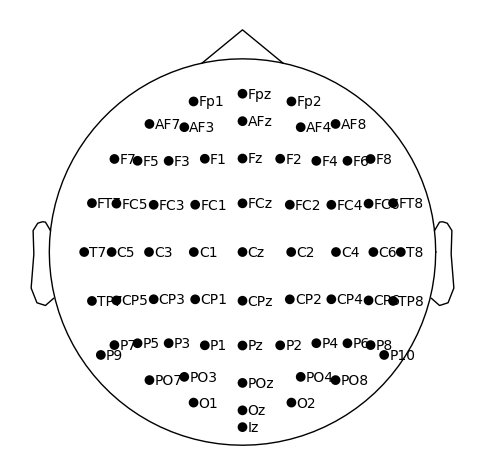

In [5]:
# Plot the montage with adjusted font size
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
mne.viz.plot_montage(jr_sim.montage, scale_factor=20, axes=ax, show_names=True)

fig.savefig('montage_plot.png', dpi=300, bbox_inches='tight')

### Generate stimulus

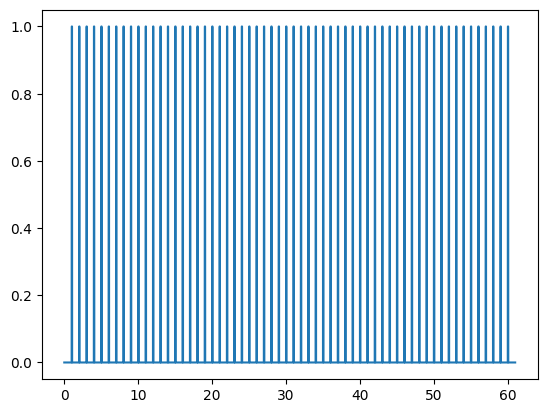

In [6]:
er_exp.plot_stimulus()

### Run an example of simulation

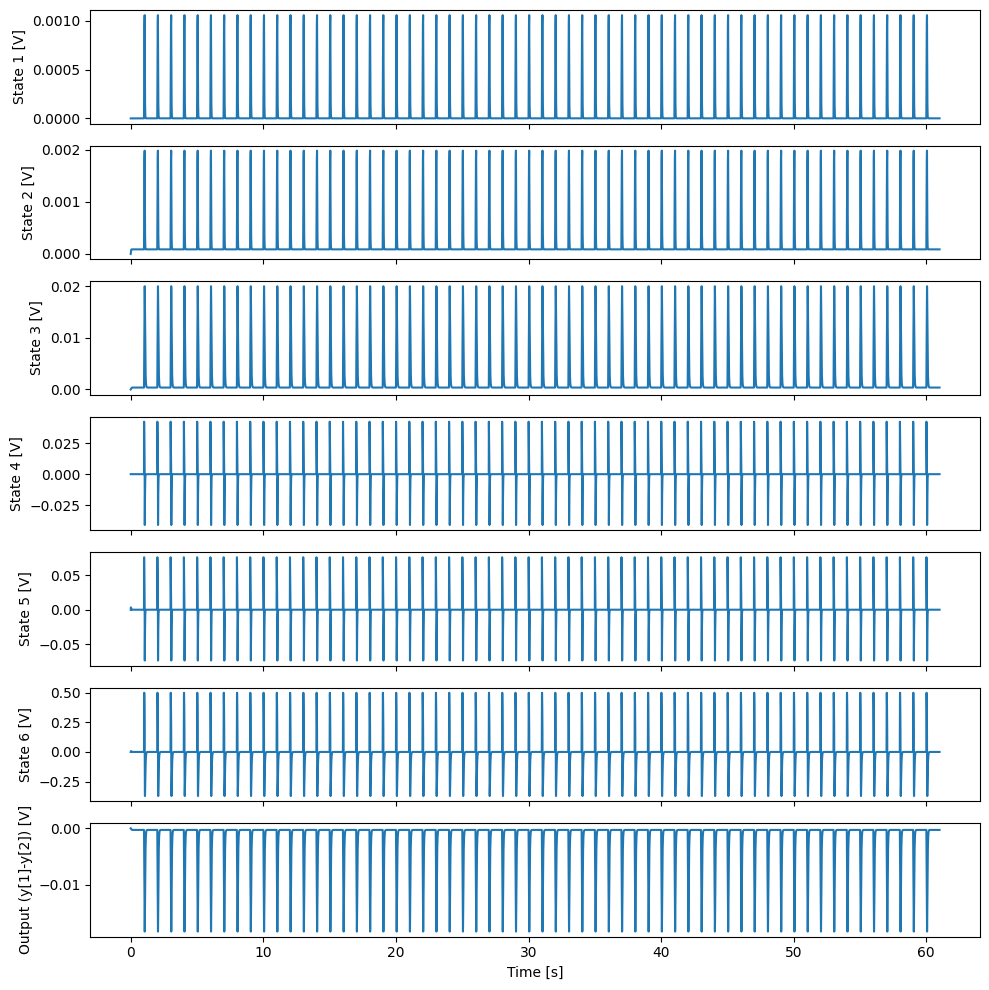

In [7]:
jr_sim.run_simulation(er_exp, parameters, jr_noise_sd=0.0)
jr_sim.plot_jr_results();

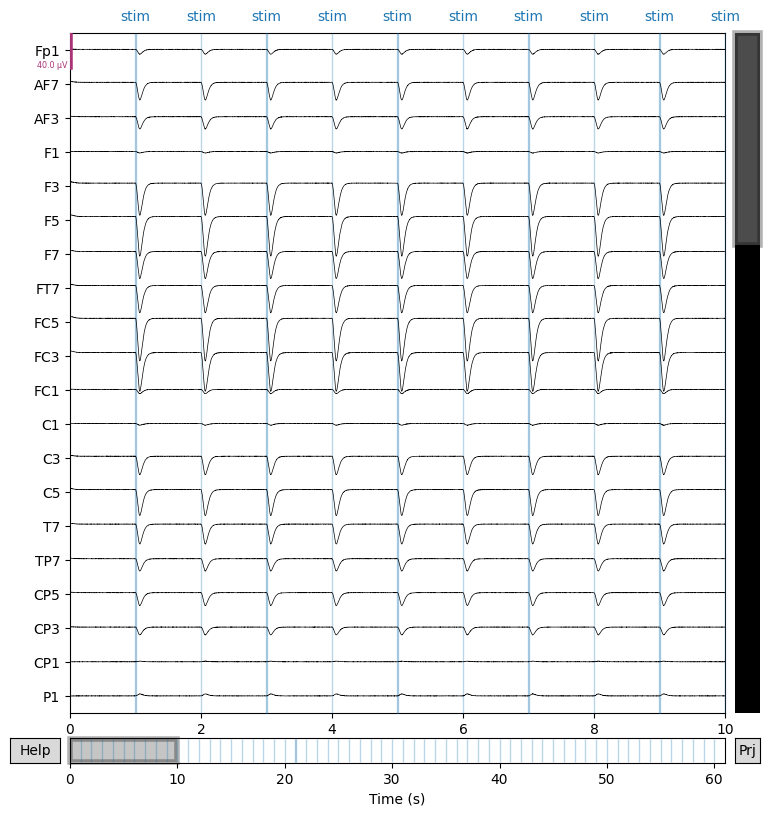

In [47]:
noise_fact = 0.1 #1e3

jr_sim.generate_raw(seed=0, noise_fact=noise_fact)
jr_sim.raw.plot();

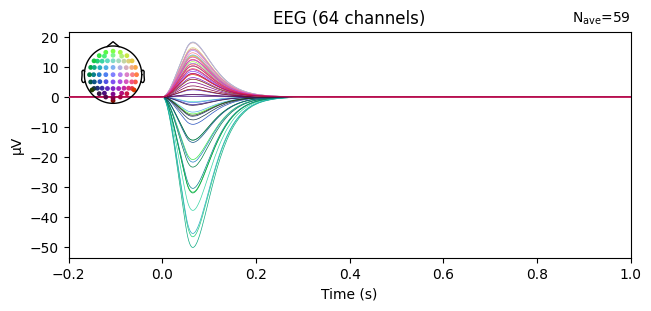

In [48]:
jr_sim.generate_evoked(er_exp)
jr_sim.evoked.plot();

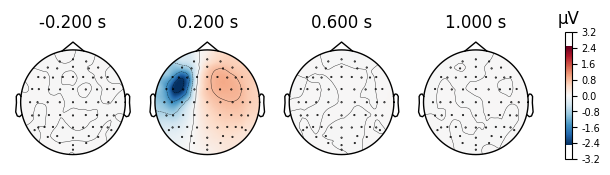

In [49]:
jr_sim.evoked.plot_topomap();

## EEG simulations

In [50]:
recompute = False
noise_fact =0.1
base_path = Path('deepjr_training_data')
base_path.mkdir(exist_ok=True)
method = 'normal'  # normal distribution of parameters
nb_sims = 1000
sim_results = SimResults(nb_sims, noise_fact, base_path)

if not sim_results.full_path.exists() or recompute:
    # Simulation per parameter calling the function
    mne.set_log_level(verbose=False)
    jr_sim.simulate_for_parameter(er_exp, method=method, 
                                  nb_sims=nb_sims, noise_fact=noise_fact,
                                  base_path=base_path, use_tqdm=True)

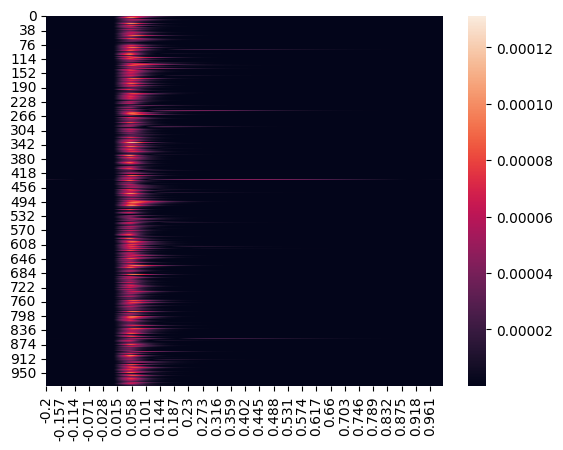

In [51]:
sim_results = SimResults(nb_sims, noise_fact, base_path)
sim_results.load()
sim_results.clean()
sim_results.plot_evoked_heatmap()

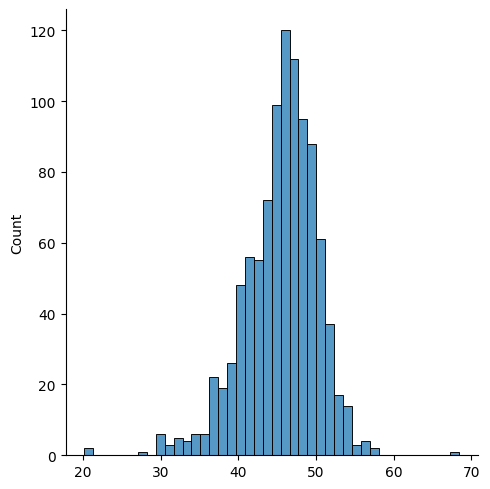

In [52]:
sns.displot(sim_results.snr)

# Training

In [53]:
from deepjr.inference import JRInvModel
from deepjr.utils import reset_random_seeds

recompute = True
epochs = 150
batch_size=32

inv_model = JRInvModel(nb_sims=nb_sims, noise_fact=noise_fact, path=base_path)

if not inv_model.full_path_model.exists() or recompute:
    reset_random_seeds()  # Reset the seeds
    inv_model.train_model(epochs, batch_size=batch_size)
    inv_model.save()
else:
    inv_model.load()

Epoch 1/150


/Users/deepatilwani/Documents/Phd_projects/DCM/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - loss: 2.8706 - mse: 0.5196 - val_loss: 2.3909 - val_mse: 0.4635
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 1.8807 - mse: 0.4151 - val_loss: 1.4411 - val_mse: 0.3728
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 0.6076 - mse: 0.3100 - val_loss: 0.5809 - val_mse: 0.3060
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - loss: -0.6106 - mse: 0.2336 - val_loss: -0.4247 - val_mse: 0.2433
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - loss: -1.6645 - mse: 0.1835 - val_loss: -1.4133 - val_mse: 0.1935
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: -2.7410 - mse: 0.1429 - val_loss: -2.4627 - val_mse: 0.1528
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - loss: -3.8449 - mse: 0.1108 - val_loss: -3.3112 - val_mse: 0.1251
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: -5.0534 - mse: 0.0839 - val_loss: -4.2756 - val_mse: 0.1000
Epoch 9/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/st

# Assessment

  0%|          | 0/50 [00:00<?, ?it/s]

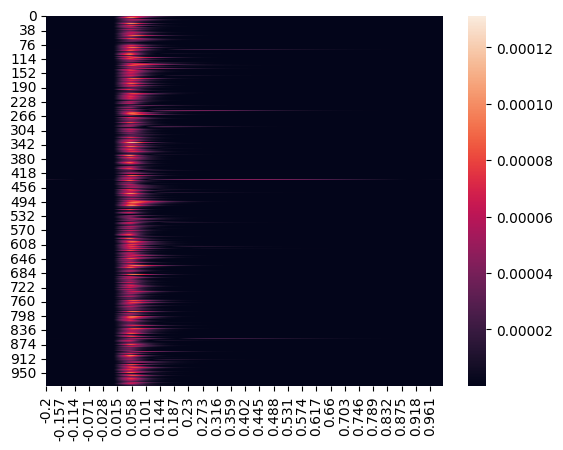

In [58]:
# Create a small testing set
mne.set_log_level(verbose=False)
jr_sim.simulate_for_parameter(er_exp, method="normal", 
                              nb_sims=50, noise_fact=noise_fact,
                              save=False, use_tqdm=True)
jr_sim.sim_results.clean()
sim_results.plot_evoked_heatmap()

dataset = jr_sim.sim_results.dataset

In [59]:
X = dataset.evoked.transpose("sim_no", "time", "ch_names").values
y = dataset.parameters.sel(param=inv_model.estim_params).values

In [60]:
inv_model.assess_model(parameter='all', X=X, y=y)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: -8.9862 - mse: 0.0343
Results for all: Loss = -8.856329917907715, MSE = 0.03508264571428299
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


,pvalue,correlation,parameter
0,0.151201,0.208163,A_e
1,0.964478,-0.006531,A_i
2,0.940646,0.010918,b_e
3,0.511624,-0.096020,b_i
4,0.562863,0.084694,a_1
5,0.191977,-0.189592,a_2
6,0.647679,-0.066939,a_3
7,0.040848,0.293265,a_4
8,0.910241,-0.016531,C


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


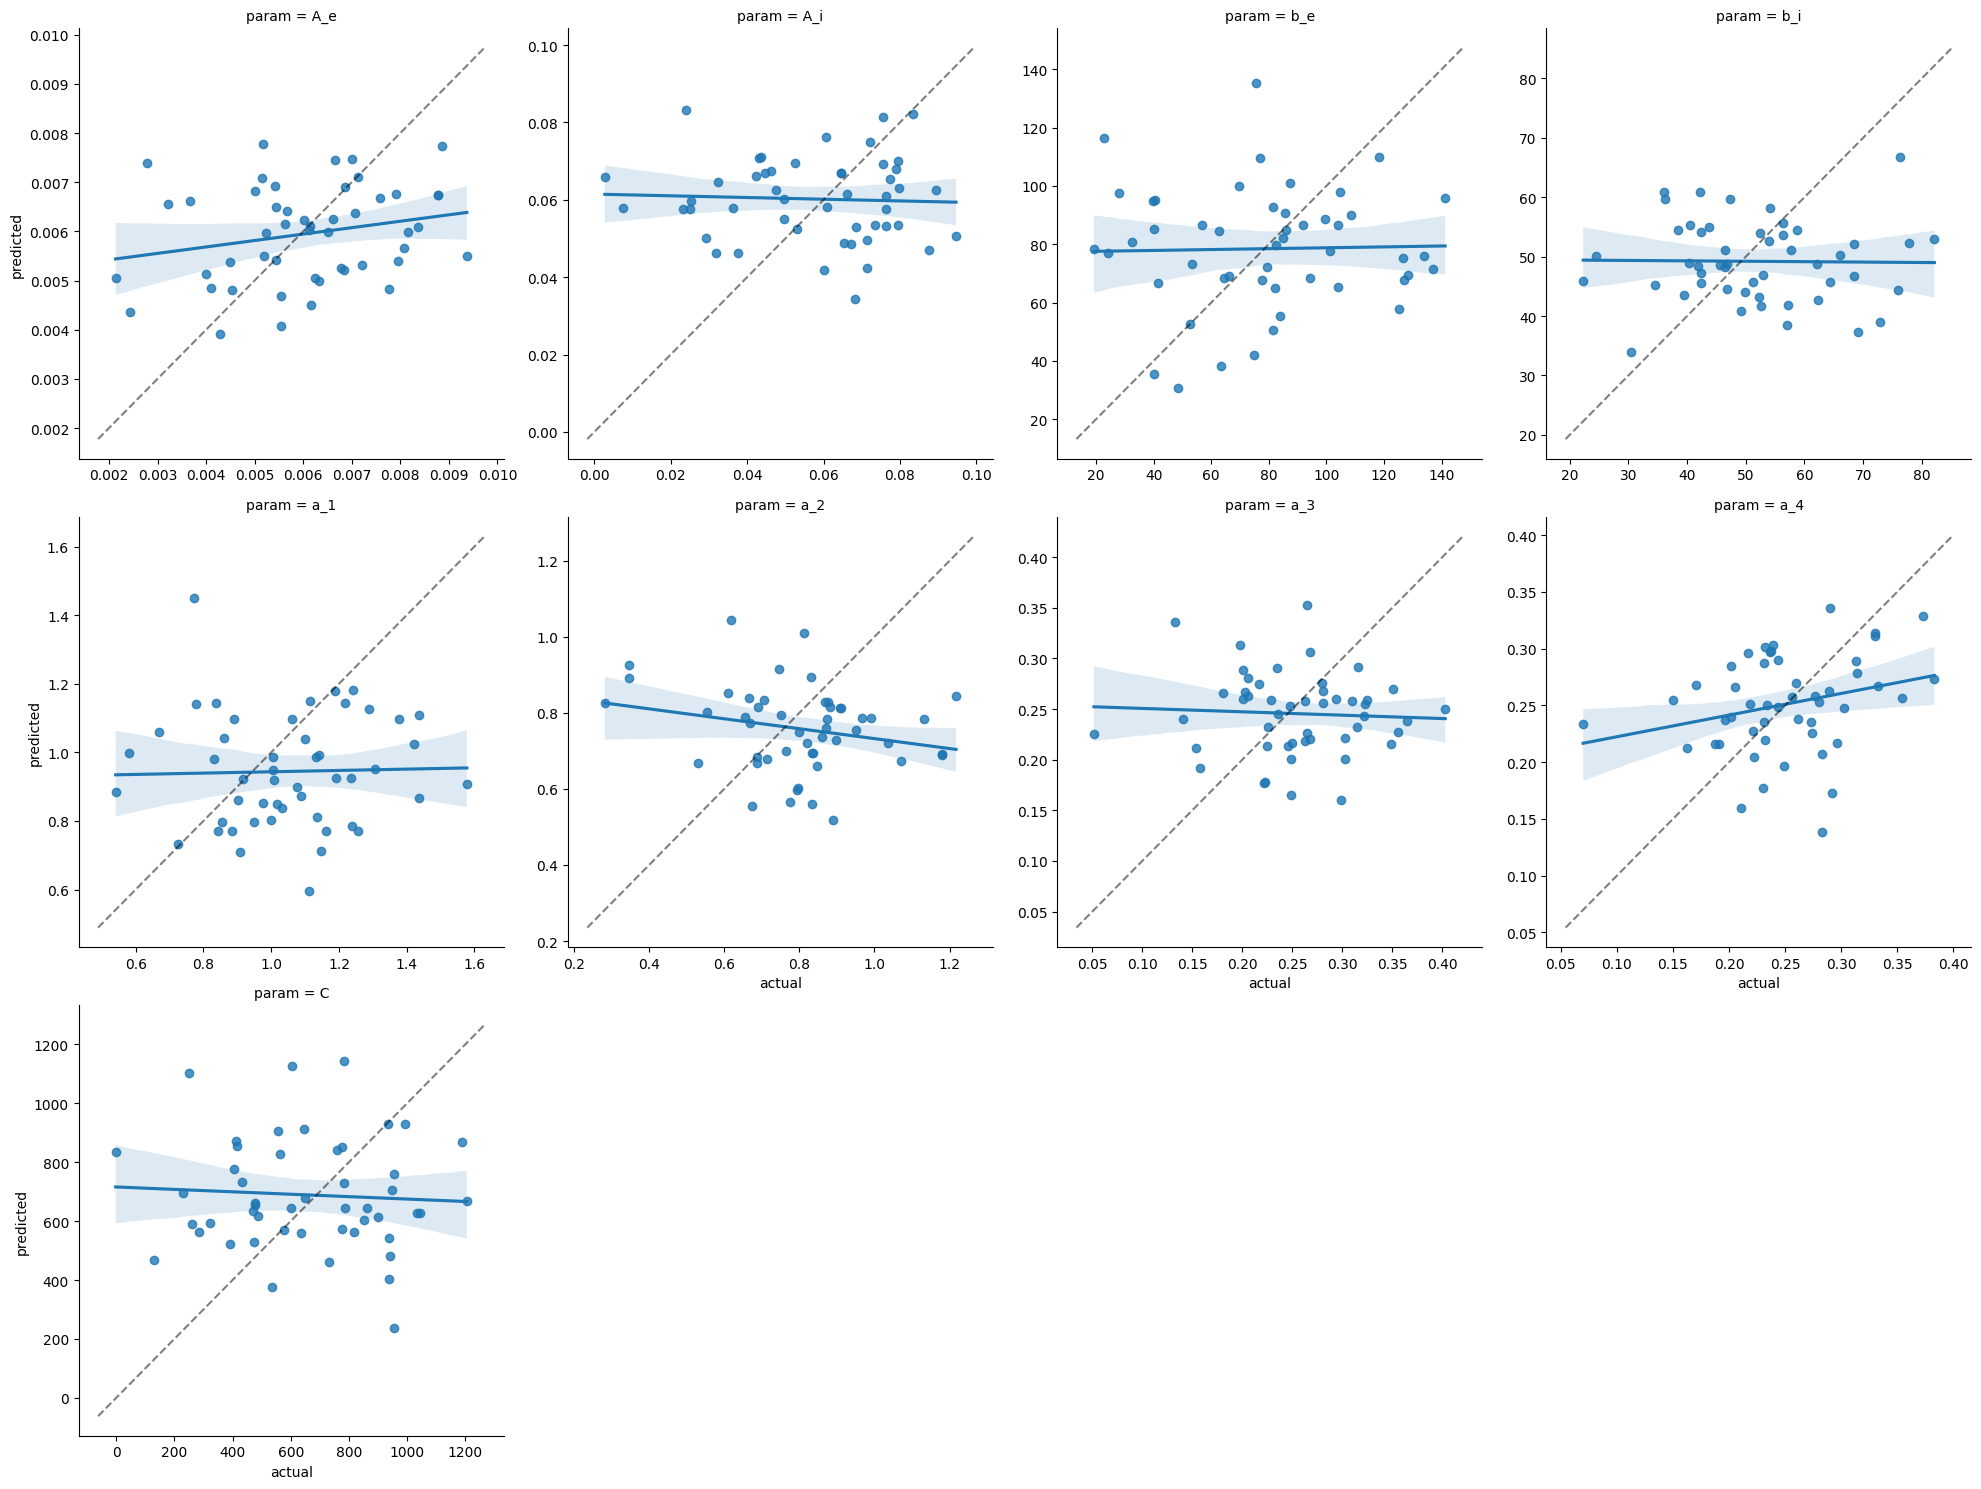

In [61]:
inv_model.plot_test_regressions(X=X, y=y)